<a href="https://colab.research.google.com/github/jihyeon602/DeepLearning_practice/blob/main/%5B%EC%8B%A4%EC%8A%B5%5D_%EC%86%8C%EC%9E%AC%EB%AC%BC%EC%84%B1_%EC%98%88%EC%B8%A1%EC%9D%84_%EC%9C%84%ED%95%9C_%EA%B7%B8%EB%9E%98%ED%94%84_%EC%8B%A0%EA%B2%BD%EB%A7%9D_(GNN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [실습] 소재물성 예측을 위한 그래프 신경망 (GNN)


## 실습 목표
---
- 토이데이터를 읽어와 GNN을 학습시켜 baseline 성능과 비교한다.
- 소재물성 데이터를 가져와 GNN 모델을 학습시킨다.


## 실습 목차
---

1. **토이데이터 전처리:** Cora 데이터 전처리 및 인공지능 모델 입력 형태로 변형

2. **베이스라인 모델 훈련:** 단순한 인공신경망을 이용해 토이데이터 훈련

3. **GNN 모델 훈련 (Cora 데이터):** GNN 모델을 토이데이터셋에 대해 훈련

4. **GNN 모델 훈련 (소재물성 데이터):** 데이터 전처리 및 GNN 모델을 이용해 소재물성 데이터 예측

5. **연습문제 :** Cora데이터 전처리 및 GNN모델링 훈련 전과정 수행

## 실습 개요
---

소재물성 예측을 위해 GNN 모델을 이해합니다.


## 1. 토이데이터 전처리

### 1.1 라이브러리 불러오기

---

필요한 라이브러리를 호출합니다.
 - **numpy**: 수치형 데이터를 배열 구조로 처리하기 위한 라이브러리
 - **pandas**: 데이터프레임을 다루기 위한 라이브러리
 - **matplotlib.pyplot**: 데이터시각화를 위한 라이브러리
 - **tensorflow** : 대표적인 딥러닝 프레임워크
 - **networkx** : 그래프와 네트워크를 연구하기위한 Python 라이브러리

In [1]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

### 1.2 Cora데이터셋 불러오기
---
문서와, 각 문서의 카테고리 분류로 이루어진 데이터\
citation : 문서의 인용/피인용 지칭 데이터\
paper: 어느 주제인지 (subject), 어느 단어가 있는지 (term) 으로 이루어져 있는 데이터

Cora 데이터세트는 노드가 머신러닝 논문을 나타내고 간선이 논문 쌍 간의 인용을 나타내는 인용 그래프입니다. 관련된 작업은 각 논문을 7가지 범주 중 하나로 분류하는 것을 목표로 하는 문서 분류입니다. 즉, 7개의 클래스가 있는 다중 클래스 분류 문제입니다.

먼저 데이터를 다운로드하고 citations 데이터를 데이터프레임화 시켜 불러오겠습니다.

In [6]:
zip_file = keras.utils.get_file(
    fname="cora.tgz",
    origin="https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz",
    extract=True,
    cache_dir="/content"
)

data_dir = os.path.join("/content", "datasets", "cora")


168052/168052 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step


In [8]:
data_dir = os.path.join("/content", "datasets", "cora_extracted","cora")

citations = pd.read_csv(
    os.path.join(data_dir, "cora.cites"),
    sep="\t",
    header=None,
    names=["target", "source"],
)
print("Citations shape:", citations.shape)


Citations shape: (5429, 2)


In [9]:
citations['source']

,source
0,1033
1,103482
2,103515
3,1050679
4,1103960
...,...
5424,19621
5425,853155
5426,1140289
5427,853118


In [10]:
citations.sample(frac=1).head()

,target,source
5224,643695,1154068
3041,39890,242663
4165,134128,1117760
954,4329,1110768
3539,67584,1127558


다음으로 papers 데이터를 판다스 데이터프레임 형태로 불러오겠습니다.

In [11]:
column_names = ["paper_id"] + [f"term_{idx}" for idx in range(1433)] + ["subject"]
papers = pd.read_csv(
    os.path.join(data_dir, "cora.content"), sep="\t", header=None, names=column_names,
)
print("Papers shape:", papers.shape)

Papers shape: (2708, 1435)


In [13]:
papers.head(10)

,paper_id,term_0,term_1,term_2,term_3,term_4,term_5,term_6,term_7,term_8,...,term_1424,term_1425,term_1426,term_1427,term_1428,term_1429,term_1430,term_1431,term_1432,subject
0,31336,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,Neural_Networks
1,1061127,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,Rule_Learning
2,1106406,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
3,13195,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
4,37879,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Probabilistic_Methods
5,1126012,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,Probabilistic_Methods
6,1107140,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Theory
7,1102850,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Neural_Networks
8,31349,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Neural_Networks
9,1106418,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Theory


In [15]:
papers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2708 entries, 0 to 2707
Columns: 1435 entries, paper_id to subject
dtypes: int64(1434), object(1)
memory usage: 29.6+ MB


papers 데이터 안의 각각의 subject들의 카운트를 확인해봅시다.

In [16]:
print(papers.subject.value_counts()) # 각 주제별 데이터 (paper) 수

subject
Neural_Networks           818
Probabilistic_Methods     426
Genetic_Algorithms        418
Theory                    351
Case_Based                298
Reinforcement_Learning    217
Rule_Learning             180
Name: count, dtype: int64


### 1.3 데이터 전처리
---
인덱스가 뒤죽박죽이므로 이를 정렬\
subject가 카테고리 인덱스로 변경합니다. (0~7 사이의 값으로 변환)

In [17]:
class_values = sorted(papers["subject"].unique())
class_idx = {name: id for id, name in enumerate(class_values)}
paper_idx = {name: idx for idx, name in enumerate(sorted(papers["paper_id"].unique()))}

In [18]:
class_idx

{'Case_Based': 0,
 'Genetic_Algorithms': 1,
 'Neural_Networks': 2,
 'Probabilistic_Methods': 3,
 'Reinforcement_Learning': 4,
 'Rule_Learning': 5,
 'Theory': 6}

In [19]:
paper_idx

{np.int64(35): 0,
 np.int64(40): 1,
 np.int64(114): 2,
 np.int64(117): 3,
 np.int64(128): 4,
 np.int64(130): 5,
 np.int64(164): 6,
 np.int64(288): 7,
 np.int64(424): 8,
 np.int64(434): 9,
 np.int64(463): 10,
 np.int64(504): 11,
 np.int64(506): 12,
 np.int64(887): 13,
 np.int64(906): 14,
 np.int64(910): 15,
 np.int64(936): 16,
 np.int64(940): 17,
 np.int64(941): 18,
 np.int64(943): 19,
 np.int64(1026): 20,
 np.int64(1033): 21,
 np.int64(1034): 22,
 np.int64(1035): 23,
 np.int64(1213): 24,
 np.int64(1237): 25,
 np.int64(1246): 26,
 np.int64(1272): 27,
 np.int64(1365): 28,
 np.int64(1385): 29,
 np.int64(1481): 30,
 np.int64(1688): 31,
 np.int64(1694): 32,
 np.int64(1717): 33,
 np.int64(1786): 34,
 np.int64(1817): 35,
 np.int64(1919): 36,
 np.int64(1949): 37,
 np.int64(1951): 38,
 np.int64(1952): 39,
 np.int64(1953): 40,
 np.int64(1955): 41,
 np.int64(1956): 42,
 np.int64(1959): 43,
 np.int64(1997): 44,
 np.int64(1999): 45,
 np.int64(2354): 46,
 np.int64(2440): 47,
 np.int64(2653): 48,
 np

In [20]:
papers["paper_id"] = papers["paper_id"].apply(lambda name: paper_idx[name])
citations["source"] = citations["source"].apply(lambda name: paper_idx[name])
citations["target"] = citations["target"].apply(lambda name: paper_idx[name])
papers["subject"] = papers["subject"].apply(lambda value: class_idx[value])

In [21]:
papers.head()

,paper_id,term_0,term_1,term_2,term_3,term_4,term_5,term_6,term_7,term_8,...,term_1424,term_1425,term_1426,term_1427,term_1428,term_1429,term_1430,term_1431,term_1432,subject
0,462,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,2
1,1911,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,5
2,2002,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
3,248,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
4,519,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3


In [22]:
citations

,target,source
0,0,21
1,0,905
2,0,906
3,0,1909
4,0,1940
...,...,...
5424,1873,328
5425,1873,1876
5426,1874,2586
5427,1876,1874


### 1.4. 데이터 시각화
---
paper의 인용/피인용 데이터를 시각화합니다. (그래프화, 특정 paper가 어떤 paper들과 연결되어있는지를 표시)\
각 노드는 논문을 나타내고 노드의 색은 subject에 해당합니다. \
이를 이후 GNN학습에 이용할 예정입니다.

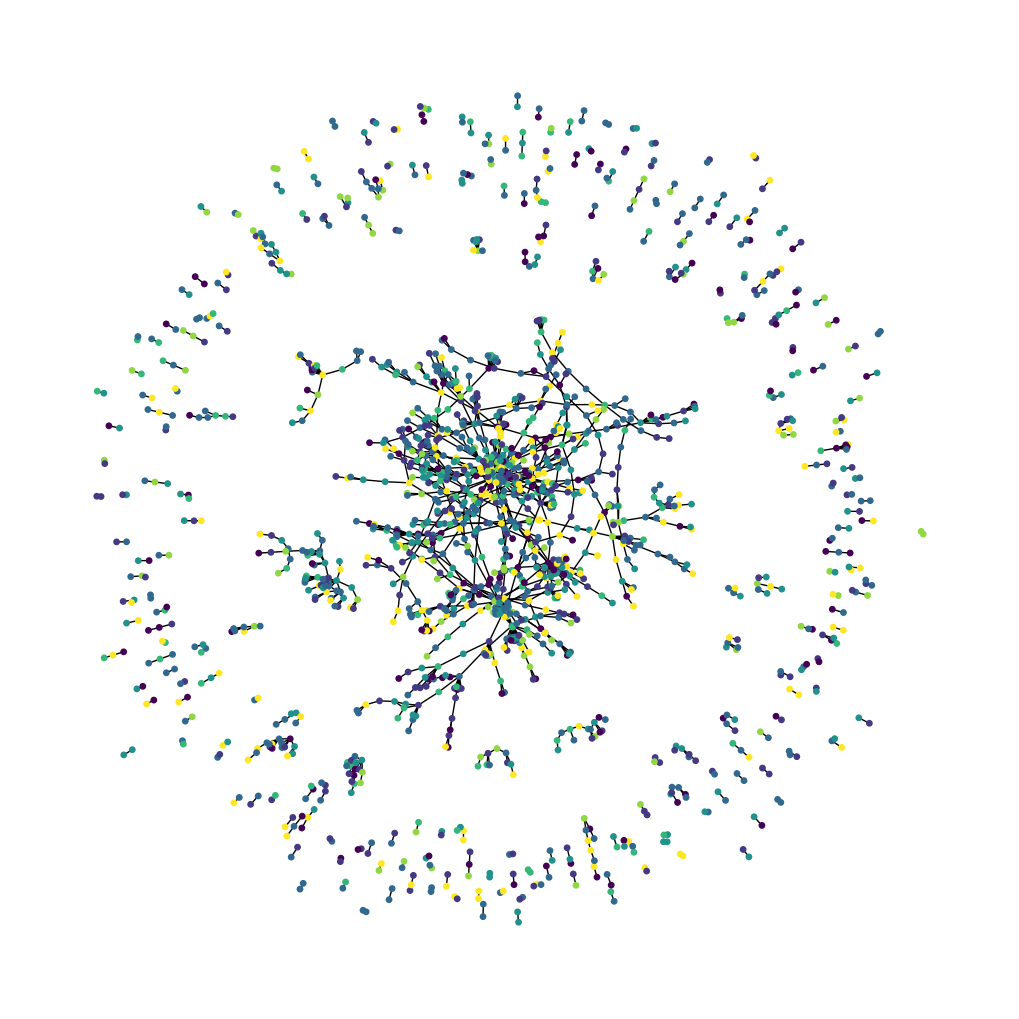

In [23]:
plt.figure(figsize=(10, 10))
colors = papers["subject"].tolist()
cora_graph = nx.from_pandas_edgelist(citations.sample(n=1500))
subjects = list(papers[papers["paper_id"].isin(list(cora_graph.nodes))]["subject"])
nx.draw_spring(cora_graph, node_size=15, node_color=subjects)

## 2. 베이스라인 모델 훈련

### 2.1. 인공신경망 인풋 준비
---
전체 데이터를 학습/시험 데이터로 분리합니다. \
그리고 훈련에 사용할 하이퍼파라미터를 선언합니다.

In [43]:
train_data, test_data = [], []

for _, group_data in papers.groupby("subject"):
    # 학습 / 시험 데이터를 1:1로 분리
    random_selection = np.random.rand(len(group_data.index)) <= 0.5
    train_data.append(group_data[random_selection])
    test_data.append(group_data[~random_selection])

train_data = pd.concat(train_data).sample(frac=1)
test_data = pd.concat(test_data).sample(frac=1)

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (1361, 1435)
Test data shape: (1347, 1435)


In [44]:
hidden_units = [32, 32]
learning_rate = 0.01
dropout_rate = 0.5
num_epochs = 300
batch_size = 256

### 2.2. 인공신경망 모델 준비
---
훈련할 모델과 훈련한 결과를 시각화할 함수를 정의합니다. 앞서 선언한 하이퍼파라미터를 이용해 훈련을 진행하도록 하겠습니다. \
아래의 순서대로 코드가 진행됩니다.
- 모델 훈련을 진행해주는 함수를 정의합니다.
- 훈련결과를 확인할 수 있는 시각화 함수를 정의합니다.
- 모델을 선언하는 함수를 정의합니다.
- Baseline 모델을 훈련할 데이터를 준비합니다.
- skip connection을 가지는 5개의 FFN block이 추가된 모델을 생성합니다.

In [50]:
# 모델 훈련 함수
def run_experiment(model, x_train, y_train):
    # 모델 컴파일
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
    )
    # early stopping 선언
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_acc", patience=70, restore_best_weights=True
    )
    # 모델 훈련
    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_split=0.15,
        callbacks=[early_stopping],
    )

    return history

In [51]:
# 훈련결과 시각화 함수
def display_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "test"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2.plot(history.history["acc"])
    ax2.plot(history.history["val_acc"])
    ax2.legend(["train", "test"], loc="upper right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    plt.show()

In [52]:
# 모델 선언 함수
def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    # 모델 구조 확인
    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation=tf.nn.gelu))

    return keras.Sequential(fnn_layers, name=name)

In [53]:
feature_names = list(set(papers.columns) - {"paper_id", "subject"})
num_features = len(feature_names)
num_classes = len(class_idx)

# 인풋 데이터를 넘파이 데이터로 변환
x_train = train_data[feature_names].to_numpy()
x_test = test_data[feature_names].to_numpy()
# 정답 데이터를 넘파이 데이터로 변환
y_train = train_data["subject"]
y_test = test_data["subject"]

In [54]:
# 모델 생성 함수
def create_baseline_model(hidden_units, num_classes, dropout_rate=0.2):
    inputs = layers.Input(shape=(num_features,), name="input_features")
    x = create_ffn(hidden_units, dropout_rate, name=f"ffn_block1")(inputs)
    for block_idx in range(4):
        # FFN 블락 생성
        x1 = create_ffn(hidden_units, dropout_rate, name=f"ffn_block{block_idx + 2}")(x)
        # Skip 연결 (ResNet 참조)
        x = layers.Add(name=f"skip_connection{block_idx + 2}")([x, x1])
    # logit 계산
    logits = layers.Dense(num_classes, name="logits")(x)
    # 모델 생성
    return keras.Model(inputs=inputs, outputs=logits, name="baseline")


baseline_model = create_baseline_model(hidden_units, num_classes, dropout_rate)
baseline_model.summary() # 모델 구조 확인

Model: "baseline"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_features      │ (None, 1433)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ffn_block1          │ (None, 32)        │     52,804 │ input_features[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ffn_block2          │ (None, 32)        │      2,368 │ ffn_block1[0][0]  │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ skip_connection2    │ (None, 32)        │          0 │ ffn_block1[0][0], │
│ (Add)               │                   │            │ ffn_block2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ffn_block3          │ (None, 32)        │      2,368 │ skip_connection2… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ skip_connection3    │ (None, 32)        │          0 │ skip_connection2… │
│ (Add)               │                   │            │ ffn_block3[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ffn_block4          │ (None, 32)        │      2,368 │ skip_connection3… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ skip_connection4    │ (None, 32)        │          0 │ skip_connection3… │
│ (Add)               │                   │            │ ffn_block4[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ffn_block5          │ (None, 32)        │      2,368 │ skip_connection4… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ skip_connection5    │ (None, 32)        │          0 │ skip_connection4… │
│ (Add)               │                   │            │ ffn_block5[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ logits (Dense)      │ (None, 7)         │        231 │ skip_connection5… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 62,507 (244.17 KB)

 Trainable params: 59,065 (230.72 KB)

 Non-trainable params: 3,442 (13.45 KB)

### 2.3. 인공신경망 모델 훈련
---

준비해놓은 데이터를 토대로 Baseline_model의 훈련을 진행하겠습니다.

In [55]:
history = run_experiment(baseline_model, x_train, y_train)

Epoch 1/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - acc: 0.1452 - loss: 3.8268 - val_acc: 0.2829 - val_loss: 1.8955
Epoch 2/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - acc: 0.2473 - loss: 2.8380 - val_acc: 0.3024 - val_loss: 1.8645
Epoch 3/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - acc: 0.2364 - loss: 2.3124 - val_acc: 0.3268 - val_loss: 1.8517
Epoch 4/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - acc: 0.2573 - loss: 2.0914 - val_acc: 0.3220 - val_loss: 1.8621
Epoch 5/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - acc: 0.2770 - loss: 2.0650 - val_acc: 0.3561 - val_loss: 1.8579
Epoch 6/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - acc: 0.3134 - loss: 1.8792 - val_acc: 0.3415 - val_loss: 1.8399
Epoch 7/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - acc: 0.3045 - loss: 1.8729 - val_acc: 0.2780 - val_loss: 1.8331
Epoch 8/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - acc: 0.3632 - loss: 1.7394 - val_acc: 0.3463 - val_loss: 1.8109
Epoch 9/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - acc: 0.3940 - loss: 1

조기 종료의 영향으로 119 epoch에서 훈련이 종료되었습니다. 그래프로 시각화해서 살펴보겠습니다.

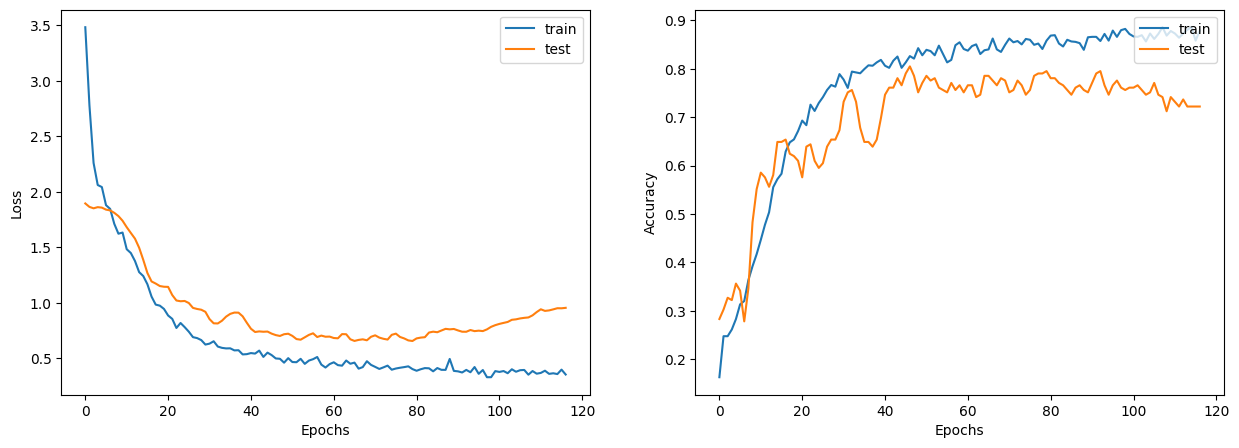

In [56]:
display_learning_curves(history)

### 2.4. 인공신경망 모델 평가
---

모델의 검증데이터를 통한 훈련 정확도를 살펴보겠습니다. \
약 73%의 결과를 보이고 있습니다.

In [57]:
_, test_accuracy = baseline_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 73.5%


## 3. GNN 훈련

### 3.1.  GNN 인풋 준비
---
데이터의 그래프화를 진행합니다. \
citation 정보를 이용해 그래프를 생성합니다.

그래프 데이터는 아래 3가지 요소로 구성되어있습니다.
- node_feature : 노드의 특성을 포함하는 넘파이 배열입니다.
- edges : 노드들 간의 희소인접행렬을 나타내는 넘파이 배열입니다.
- edge_weights : 그래프의 노드 간의 관계를 정량화하는 edge 가중치를 포함하는 넘파이 배열입니다. \
각각의 정의해 graph_info에 담아줍니다.

In [58]:
# edge arry 생성 [2, num_edges].
edges = citations[["source", "target"]].to_numpy().T
# edge의 weight를 1로 초기화 [len(edges),]
edge_weights = tf.ones(shape=edges.shape[1])
# node의 feature array 생성 [num_nodes, num_features]
node_features = tf.cast(
    papers.sort_values("paper_id")[feature_names].to_numpy(), dtype=tf.dtypes.float32
)

# 위 정보들을 모두 담은 graph_info 튜플 변수 선언
graph_info = (node_features, edges, edge_weights)

print("Edges shape:", edges.shape)
print("Nodes shape:", node_features.shape)

Edges shape: (2, 5429)
Nodes shape: (2708, 1433)


### 3.2.  GNN 모델 준비
---

GNN 모델을 수행하기 위한 준비를 하겠습니다. 먼저 GraphConvLayer를 활용하기 위해 함수로 정의합니다. \
GraphConvLayer를 정의하기위해서는 prepare , Aggregate, Update 3단계를 정의합니다.

In [59]:
# GNN Layer 준비
class GraphConvLayer(layers.Layer):
    def __init__(
        self,
        hidden_units,
        dropout_rate=0.2,
        aggregation_type="mean",
        combination_type="concat",
        normalize=False,
        *args,
        **kwargs,
    ):
        super(GraphConvLayer, self).__init__(*args, **kwargs)

        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.normalize = normalize

        self.ffn_prepare = create_ffn(hidden_units, dropout_rate)
        if self.combination_type == "gated":
            self.update_fn = layers.GRU(
                units=hidden_units,
                activation="tanh",
                recurrent_activation="sigmoid",
                dropout=dropout_rate,
                return_state=True,
                recurrent_dropout=dropout_rate,
            )
        else:
            self.update_fn = create_ffn(hidden_units, dropout_rate)

    def prepare(self, node_repesentations, weights=None):
        # node_repesentations shape:  [num_edges, embedding_dim].
        messages = self.ffn_prepare(node_repesentations)
        if weights is not None:
            messages = messages * tf.expand_dims(weights, -1)
        return messages

    def aggregate(self, node_indices, neighbour_messages):
        # node_indices shape: [num_edges].
        # neighbour_messages shape: [num_edges, representation_dim].
        num_nodes = tf.math.reduce_max(node_indices) + 1
        if self.aggregation_type == "sum":
            aggregated_message = tf.math.unsorted_segment_sum(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "mean":
            aggregated_message = tf.math.unsorted_segment_mean(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "max":
            aggregated_message = tf.math.unsorted_segment_max(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        else:
            raise ValueError(f"Invalid aggregation type: {self.aggregation_type}.")

        return aggregated_message

    def update(self, node_repesentations, aggregated_messages):
        # node_repesentations shape: [num_nodes, representation_dim].
        # aggregated_messages shape: [num_nodes, representation_dim].
        if self.combination_type == "gru":
            # Create a sequence of two elements for the GRU layer.
            h = tf.stack([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "concat":
            # node_repesentations and aggregated_messages 붙힘 (concat)
            h = tf.concat([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "add":
            # node_repesentations and aggregated_messages 더하기
            h = node_repesentations + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        # Apply the processing function.
        node_embeddings = self.update_fn(h)
        if self.combination_type == "gru":
            node_embeddings = tf.unstack(node_embeddings, axis=1)[-1]

        if self.normalize:
            node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)
        return node_embeddings

    def call(self, inputs):
        """Process the inputs to produce the node_embeddings.

        inputs: a tuple of three elements: node_repesentations, edges, edge_weights.
        Returns: node_embeddings of shape [num_nodes, representation_dim].
        """

        node_repesentations, edges, edge_weights = inputs
        # Get node_indices (source) and neighbour_indices (target) from edges.
        node_indices, neighbour_indices = edges[0], edges[1]
        # neighbour_repesentations shape is [num_edges, representation_dim].
        neighbour_repesentations = tf.gather(node_repesentations, neighbour_indices)

        # Prepare the messages of the neighbours.
        neighbour_messages = self.prepare(neighbour_repesentations, edge_weights)
        # Aggregate the neighbour messages.
        aggregated_messages = self.aggregate(node_indices, neighbour_messages)
        # Update the node embedding with the neighbour messages.
        return self.update(node_repesentations, aggregated_messages)

분류 문제를 해결하기 위한 GNN 분류기를 구현합니다. \
- 아래 과정을 따릅니다.
1. 초기 노드 표현을 생성하기 위해 FFN을 사용한 전처리를 적용합니다.
2. skip연결이 있는 GraphConvLayer를 노드 표현에 적용해 노드 임베딩을 생성합니다.
3. FFN을 사용한 후 노드 임베딩을 적용해 최종 노드 임베딩을 생성합니다.
4. softmax 계층을 통과시켜 노드 클래스를 예측합니다.


In [60]:
# GNN 모델 선언
class GNNNodeClassifier(tf.keras.Model):
    def __init__(
        self,
        graph_info,
        num_classes,
        hidden_units,
        aggregation_type="sum",
        combination_type="concat",
        dropout_rate=0.2,
        normalize=True,
        *args,
        **kwargs,
    ):
        super(GNNNodeClassifier, self).__init__(*args, **kwargs)

        # Unpack graph_info to three elements: node_features, edges, and edge_weight.
        node_features, edges, edge_weights = graph_info
        self.node_features = node_features
        self.edges = edges
        self.edge_weights = edge_weights
        # Set edge_weights to ones if not provided.
        if self.edge_weights is None:
            self.edge_weights = tf.ones(shape=edges.shape[1])
        # Scale edge_weights to sum to 1.
        self.edge_weights = self.edge_weights / tf.math.reduce_sum(self.edge_weights)

        # Create a process layer.
        self.preprocess = create_ffn(hidden_units, dropout_rate, name="preprocess")
        # Create the first GraphConv layer.
        self.conv1 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv1",
        )
        # Create the second GraphConv layer.
        self.conv2 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv2",
        )
        # Create a postprocess layer.
        self.postprocess = create_ffn(hidden_units, dropout_rate, name="postprocess")
        # Create a compute logits layer.
        self.compute_logits = layers.Dense(units=num_classes, name="logits")

    def call(self, input_node_indices):
        # Preprocess the node_features to produce node representations.
        x = self.preprocess(self.node_features)
        # Apply the first graph conv layer.
        x1 = self.conv1((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x1 + x
        # Apply the second graph conv layer.
        x2 = self.conv2((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x2 + x
        # Postprocess node embedding.
        x = self.postprocess(x)
        # Fetch node embeddings for the input node_indices.
        node_embeddings = tf.gather(x, input_node_indices)
        # Compute logits
        return self.compute_logits(node_embeddings)

모델을 생성하고 구조를 확인합니다.

In [61]:
gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gnn_model",
)

# 노드 인덱스를 텐서로 변환
node_indices = tf.convert_to_tensor([1, 10, 100])

# 모델에 텐서 입력
print("GNN output shape:", gnn_model(node_indices))

# 모델 구조 확인
gnn_model.summary()

GNN output shape: tf.Tensor(
[[-0.08769206 -0.20608911 -0.02431767  0.22528693 -0.06504108 -0.03622137
   0.08628676]
 [-0.03507661 -0.08614248  0.05538744  0.03541131 -0.04166353 -0.00933975
   0.05420048]
 [ 0.02007447  0.09887534 -0.02561346 -0.02696717  0.00209533 -0.0042404
  -0.01074812]], shape=(3, 7), dtype=float32)


Model: "gnn_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ preprocess (Sequential)         │ (2708, 32)             │        52,804 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ graph_conv1 (GraphConvLayer)    │ ?                      │         5,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ graph_conv2 (GraphConvLayer)    │ ?                      │         5,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ postprocess (Sequential)        │ (2708, 32)             │         2,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ logits (Dense)                  │ (3, 7)                 │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,179 (262.42 KB)

 Trainable params: 63,481 (247.97 KB)

 Non-trainable params: 3,698 (14.45 KB)

### 3.3.  GNN 모델 훈련
---

이제 데이터와 모델 준비가 끝났습니다. 본격적으로 학습을 진행해보겠습니다.

In [62]:
# x_train.shape
y_train.shape # 인풋데이터 확인

(1361,)

In [63]:
# 인풋: 노드의 인덱스
# 아웃풋: 노드와 엣지 정보를 이용하여 나온 예측결과
x_train = train_data.paper_id.to_numpy()
history = run_experiment(gnn_model, x_train, y_train)

Epoch 1/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - acc: 0.2281 - loss: 1.8968 - val_acc: 0.3902 - val_loss: 1.7100
Epoch 2/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - acc: 0.4468 - loss: 1.5687 - val_acc: 0.4634 - val_loss: 1.4282
Epoch 3/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - acc: 0.6049 - loss: 1.1066 - val_acc: 0.5268 - val_loss: 1.3463
Epoch 4/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - acc: 0.6979 - loss: 0.7792 - val_acc: 0.5756 - val_loss: 1.3888
Epoch 5/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - acc: 0.8089 - loss: 0.5191 - val_acc: 0.5951 - val_loss: 1.3284
Epoch 6/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - acc: 0.8904 - loss: 0.3284 - val_acc: 0.6341 - val_loss: 1.4547
Epoch 7/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - acc: 0.9443 - loss: 0.1703 - val_acc: 0.6780 - val_loss: 1.3297
Epoch 8/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - acc: 0.9676 - loss: 0.1095 - val_acc: 0.6585 - val_loss: 1.5862
Epoch 9/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - acc: 0.9743 - loss: 

훈련 결과를 시각화를 통해 살펴보겠습니다. 조기 종료로 인해 156 epoch까지 훈련이 진행되었습니다.

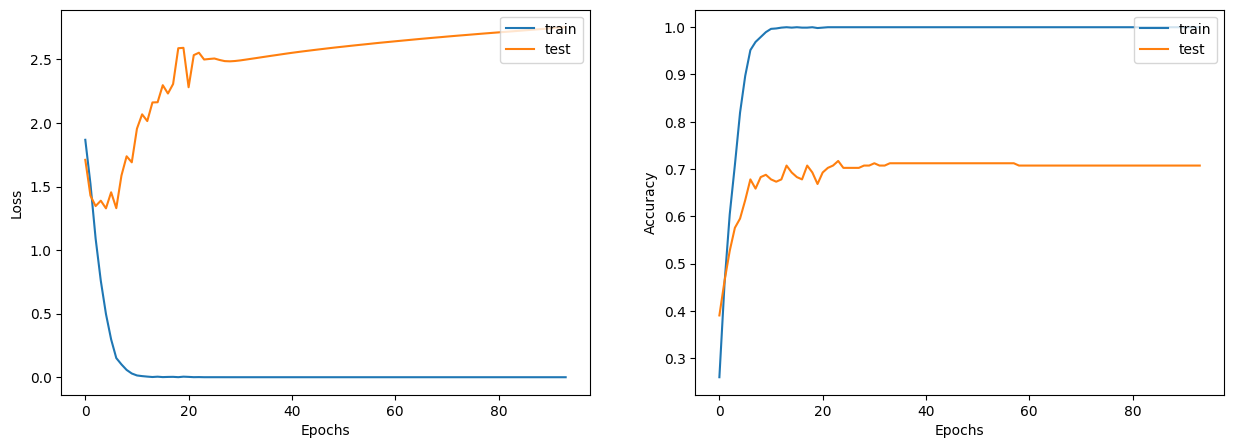

In [64]:
display_learning_curves(history)

### 3.4.  GNN 모델 평가
---

결과를 정확도를 통해 알아보겠습니다. 79%로 이전 Baseline 모델보다 좋은 성능을 보이고 있는것을 확인할 수 있습니다.

In [65]:
x_test = test_data.paper_id.to_numpy()
_, test_accuracy = gnn_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 69.56%


## 4. GNN을 이용한 소재물성 예측

### 4.1.  라이브러리 임포트
---

필요한 라이브러리를 호출합니다.
 - **numpy**: 수치형 데이터를 배열 구조로 처리하기 위한 라이브러리
 - **pandas**: 데이터프레임을 다루기 위한 라이브러리
 - **matplotlib.pyplot**: 데이터시각화를 위한 라이브러리
 - **seaborn**: 시각화 라이브러리
 - **sklearn**: 다양한 분류, 회귀, 그리고 서포트 벡터 머신, 랜덤 포레스트, 그라디언트 부스팅, k-평균, DBSCAN을 포함한 클러스터링 알고리즘을 사용가능한 기계학습 라이브러리

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss,mean_squared_error
%matplotlib inline
seed=42

### 4.2. 데이터 로드
---

소재 물성 데이터를 로드합니다.

In [67]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [68]:
print('Number of rows and columns in train data set:',train.shape)
print('Number of rows and columns in test data  set:',test.shape)

Number of rows and columns in train data set: (2400, 14)
Number of rows and columns in test data  set: (600, 12)


In [69]:
train.head()

,id,spacegroup,number_of_total_atoms,percent_atom_al,percent_atom_ga,percent_atom_in,lattice_vector_1_ang,lattice_vector_2_ang,lattice_vector_3_ang,lattice_angle_alpha_degree,lattice_angle_beta_degree,lattice_angle_gamma_degree,formation_energy_ev_natom,bandgap_energy_ev
0,1,33,80.0,0.6250,0.3750,0.000,9.9523,8.5513,9.1775,90.0026,90.0023,90.0017,0.0680,3.4387
1,2,194,80.0,0.6250,0.3750,0.000,6.1840,6.1838,23.6287,90.0186,89.9980,120.0025,0.2490,2.9210
2,3,227,40.0,0.8125,0.1875,0.000,9.7510,5.6595,13.9630,90.9688,91.1228,30.5185,0.1821,2.7438
3,4,167,30.0,0.7500,0.0000,0.250,5.0036,5.0034,13.5318,89.9888,90.0119,120.0017,0.2172,3.3492
4,5,194,80.0,0.0000,0.6250,0.375,6.6614,6.6612,24.5813,89.9960,90.0006,119.9893,0.0505,1.3793


Regression 모델 평가를 위한 RMSLE(Root Mean Squared Error)를 생성하는 함수를 정의합니다.

In [70]:
def rmsle(y_true,y_pred):
    return np.sqrt(np.square(np.log(y_pred + 1) - np.log(y_true + 1)).mean())

### 4.3.  데이터 전처리 및 컬럼 추가
---

소재물성 데이터의 전처리를 진행하겠습니다. \
먼저 데이터의 분포를 살펴보고, discribe()를 사용해 통께 지표와 corr()를 활용해 상관관계를 살펴보겠습니다. \
이후 데이터에 필요한 컬럼들을 추가해주도록 하겠습니다.

<ipython-input-71-04750c20105a>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train['formation_energy_ev_natom'],bins=50,ax=ax1,color='b')
<ipython-input-71-04750c20105a>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train['bandgap_energy_ev'],bins=50,ax=ax2,color='r')


<Axes: xlabel='bandgap_energy_ev', ylabel='Density'>

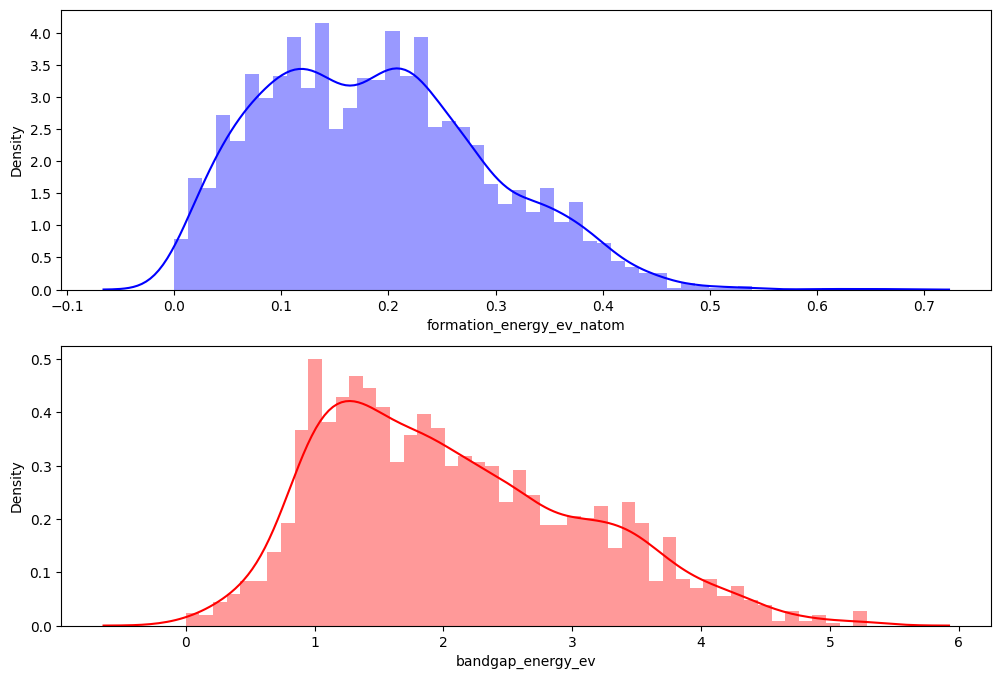

In [71]:
fig,ax = plt.subplots(2,1,figsize=(12,8))
ax1,ax2 = ax.flatten()
sns.distplot(train['formation_energy_ev_natom'],bins=50,ax=ax1,color='b')
sns.distplot(train['bandgap_energy_ev'],bins=50,ax=ax2,color='r')

In [72]:
train.describe()

,id,spacegroup,number_of_total_atoms,percent_atom_al,percent_atom_ga,percent_atom_in,lattice_vector_1_ang,lattice_vector_2_ang,lattice_vector_3_ang,lattice_angle_alpha_degree,lattice_angle_beta_degree,lattice_angle_gamma_degree,formation_energy_ev_natom,bandgap_energy_ev
count,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000
mean,1200.500000,141.517917,61.679167,0.385439,0.308601,0.305958,10.030005,7.086977,12.593288,90.243666,92.398971,94.787600,0.187614,2.077205
std,692.964646,84.715548,22.598337,0.265566,0.233717,0.263198,5.645457,1.890330,5.450746,1.333655,5.299734,25.868516,0.104100,1.006845
min,1.000000,12.000000,10.000000,0.000000,0.000000,0.000000,3.037000,2.942300,5.672500,82.744100,81.641300,29.727400,0.000000,0.000100
25%,600.750000,33.000000,40.000000,0.166700,0.093800,0.062500,6.141100,5.833625,9.298000,89.999700,90.000900,89.998700,0.105600,1.278500
50%,1200.500000,194.000000,80.000000,0.375000,0.281200,0.250000,9.537450,6.382950,10.125000,90.001700,90.003550,90.000400,0.181800,1.907850
75%,1800.250000,206.000000,80.000000,0.583300,0.468800,0.468800,10.292100,9.093450,14.372050,90.006200,90.014400,119.998325,0.256275,2.761950
max,2400.000000,227.000000,80.000000,1.000000,1.000000,1.000000,24.913400,10.290300,25.346000,101.229800,106.168200,120.053500,0.657200,5.286100


<Axes: >

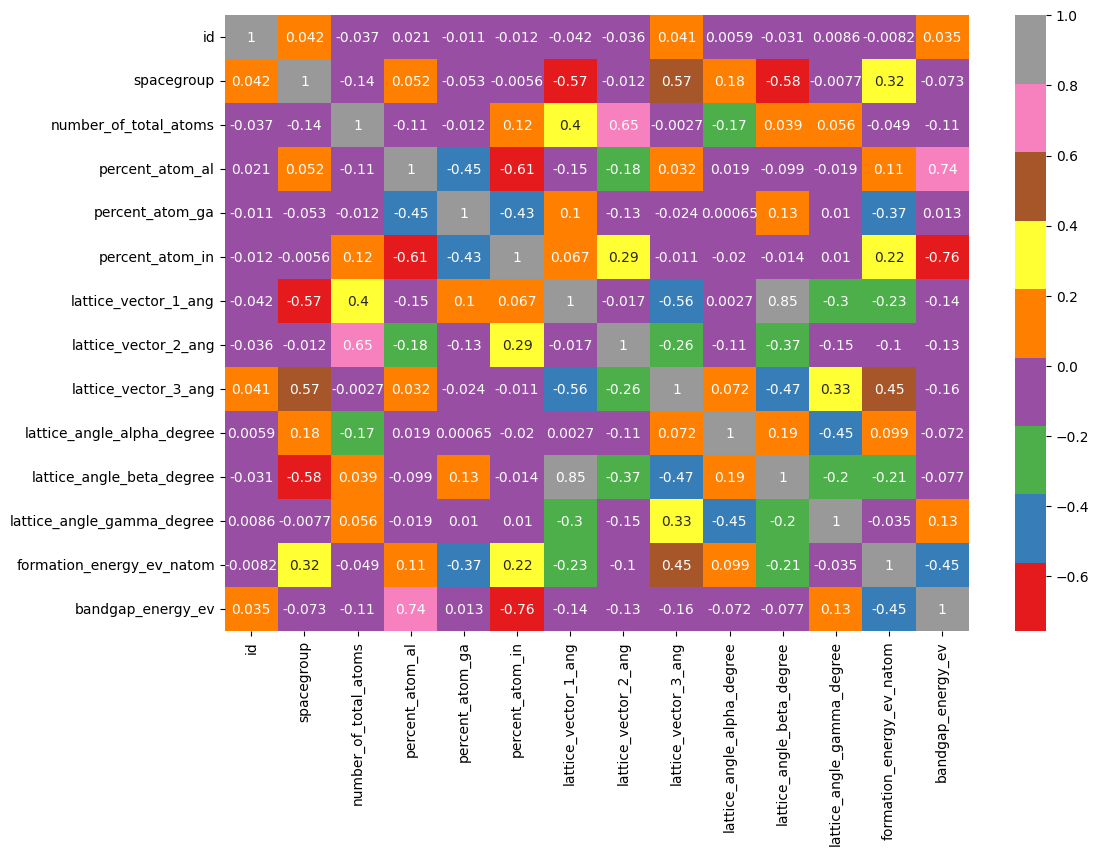

In [73]:
cor = train.corr()
plt.figure(figsize=(12,8))
sns.heatmap(cor,cmap='Set1',annot=True)

#### 4.3.1추가 컬럼: degree --> radian

---

radian에 degree칼럼을 추가해줍니다.

In [74]:
# Degree to radian
train['alpha_rad'] = np.radians(train['lattice_angle_alpha_degree'])
train['beta_rad'] = np.radians(train['lattice_angle_beta_degree'])
train['gamma_rad'] = np.radians(train['lattice_angle_gamma_degree'])

test['alpha_rad'] = np.radians(test['lattice_angle_alpha_degree'])
test['beta_rad'] = np.radians(test['lattice_angle_beta_degree'])
test['gamma_rad'] = np.radians(test['lattice_angle_gamma_degree'])

#### 4.3.2 추가 컬럼: density

---

density 칼럼도 추가해줍니다.

In [75]:
def vol(df):
    volumn = df['lattice_vector_1_ang']*df['lattice_vector_2_ang']*df['lattice_vector_3_ang']*np.sqrt(
    1 + 2*np.cos(df['alpha_rad'])*np.cos(df['beta_rad'])*np.cos(df['gamma_rad'])
    -np.cos(df['alpha_rad'])**2
    -np.cos(df['beta_rad'])**2
    -np.cos(df['gamma_rad'])**2)
    df['volumn'] = volumn

In [76]:
vol(train)
vol(test)

In [77]:
# Atomic density
train['density'] = train['number_of_total_atoms'] / train['volumn']
test['density'] = test['number_of_total_atoms'] / test['volumn']

#### 4.3.3 추가 컬럼: 평균값, 중앙값

---

평균값과 중앙값또한 추가해주도록 하겠습니다.

In [78]:
def mean_median_feature(df):
        print('# Mean & Median range')
        dmean = df.mean()
        dmedian = df.median()
        #q0_1 = df.quantile(0.1)
        #q0_99 = df.quantile(0.99)
        q1 = df.quantile(0.25)
        q3 = df.quantile(0.75)
        col = df.columns
        del_col = ['id','formation_energy_ev_natom','bandgap_energy_ev']
        col = [w for w in col if w not in del_col]

        for c in col:
            df['mean_'+c] = (df[c] > dmean[c]).astype(np.uint8)
            df['median_'+c] = (df[c] > dmedian[c]).astype(np.uint8)
            df['q1_'+c] = (df[c] < q1[c]).astype(np.uint8)
            df['q3_'+c] = (df[c] > q3[c]).astype(np.uint8)

        print('Shape',df.shape)


mean_median_feature(train)
mean_median_feature(test)

# Mean & Median range
Shape (2400, 83)
# Mean & Median range
Shape (600, 81)


In [79]:
train.head()

,id,spacegroup,number_of_total_atoms,percent_atom_al,percent_atom_ga,percent_atom_in,lattice_vector_1_ang,lattice_vector_2_ang,lattice_vector_3_ang,lattice_angle_alpha_degree,...,q1_gamma_rad,q3_gamma_rad,mean_volumn,median_volumn,q1_volumn,q3_volumn,mean_density,median_density,q1_density,q3_density
0,1,33,80.0,0.6250,0.3750,0.000,9.9523,8.5513,9.1775,90.0026,...,0,0,1,0,0,0,1,1,0,1
1,2,194,80.0,0.6250,0.3750,0.000,6.1840,6.1838,23.6287,90.0186,...,0,1,1,0,0,0,1,1,0,1
2,3,227,40.0,0.8125,0.1875,0.000,9.7510,5.6595,13.9630,90.9688,...,1,0,0,0,1,0,1,1,0,1
3,4,167,30.0,0.7500,0.0000,0.250,5.0036,5.0034,13.5318,89.9888,...,0,1,0,0,1,0,1,1,0,1
4,5,194,80.0,0.0000,0.6250,0.375,6.6614,6.6612,24.5813,89.9960,...,0,0,1,1,0,1,0,0,1,0


#### 4.3.4 spacegroup을 통한 데이터 그래프화

---

In [80]:
edge_node = train[['id', 'spacegroup']]

col = ['formation_energy_ev_natom','bandgap_energy_ev']
X = train.drop(['id']+col,axis=1)
y = train[col]
x_test = test.drop(['id'],axis=1)

In [81]:
edge_node

,id,spacegroup
0,1,33
1,2,194
2,3,227
3,4,167
4,5,194
...,...,...
2395,2396,33
2396,2397,167
2397,2398,206
2398,2399,33


#### 4.3.5 데이터 스케일링

---

In [82]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_scaled = sc.fit_transform(X)
x_test_scaled = sc.fit_transform(x_test)
y = y.values

In [83]:
y_test

,subject
616,2
2144,3
1099,1
2071,0
690,0
...,...
1653,0
1541,1
2608,2
1448,0


In [84]:
X_scaled.shape

(2400, 80)

#### 4.3.6 그래프 데이터 전처리

---

In [85]:
# edge arry 생성 [2, num_edges].
edges = edge_node[["id", "spacegroup"]].to_numpy().T
# edge의 weight를 1로 초기화 [len(edges),]
edge_weights = tf.ones(shape=edges.shape[1])
# node의 feature array 생성 [num_nodes, num_features]
node_features = tf.cast(
    X_scaled, dtype=tf.dtypes.float32
)

# 위 정보들을 모두 담은 graph_info 튜플 변수 선언
graph_info = (node_features, edges, edge_weights)

print("Edges shape:", edges.shape)
print("Nodes shape:", node_features.shape)

Edges shape: (2, 2400)
Nodes shape: (2400, 80)


모델 훈련에 사용할 데이터의 전처리와 준비가 완료되었습니다. 본격적으로 예측과정을 수행해보도록 하겠습니다.

### 4.4 소재 물성 예측 모델 선언 (regression)
---

앞서 살펴본 GNN 모델과 같은 방식으로 활용하도록 하겠습니다. \
먼저 GNN Layer를 생성하고, 이후 모델 생성 함수를 정의합니다.

In [86]:
# GNN Layer 준비
class GraphConvLayer(layers.Layer):
    def __init__(
        self,
        hidden_units,
        dropout_rate=0.2,
        aggregation_type="mean",
        combination_type="concat",
        normalize=False,
        *args,
        **kwargs,
    ):
        super(GraphConvLayer, self).__init__(*args, **kwargs)

        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.normalize = normalize

        self.ffn_prepare = create_ffn(hidden_units, dropout_rate)
        if self.combination_type == "gated":
            self.update_fn = layers.GRU(
                units=hidden_units,
                activation="tanh",
                recurrent_activation="sigmoid",
                dropout=dropout_rate,
                return_state=True,
                recurrent_dropout=dropout_rate,
            )
        else:
            self.update_fn = create_ffn(hidden_units, dropout_rate)

    def prepare(self, node_repesentations, weights=None):
        # node_repesentations shape:  [num_edges, embedding_dim].
        messages = self.ffn_prepare(node_repesentations)
        if weights is not None:
            messages = messages * tf.expand_dims(weights, -1)
        return messages

    def aggregate(self, node_indices, neighbour_messages, node_representations):
        # node_indices shape: [num_edges].
        # neighbour_messages shape: [num_edges, representation_dim].
        # num_nodes = tf.math.reduce_max(node_indices) + 1
        num_nodes = node_representations.shape[0]

        if self.aggregation_type == "sum":
            aggregated_message = tf.math.unsorted_segment_sum(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "mean":
            aggregated_message = tf.math.unsorted_segment_mean(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "max":
            aggregated_message = tf.math.unsorted_segment_max(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        else:
            raise ValueError(f"Invalid aggregation type: {self.aggregation_type}.")

        return aggregated_message

    def update(self, node_repesentations, aggregated_messages):
        # node_repesentations shape: [num_nodes, representation_dim].
        # aggregated_messages shape: [num_nodes, representation_dim].
        if self.combination_type == "gru":
            # Create a sequence of two elements for the GRU layer.
            h = tf.stack([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "concat":
            # node_repesentations and aggregated_messages 붙힘 (concat)
            h = tf.concat([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "add":
            # node_repesentations and aggregated_messages 더하기
            h = node_repesentations + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        # Apply the processing function.
        node_embeddings = self.update_fn(h)
        if self.combination_type == "gru":
            node_embeddings = tf.unstack(node_embeddings, axis=1)[-1]

        if self.normalize:
            node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)
        return node_embeddings

    def call(self, inputs):
        """Process the inputs to produce the node_embeddings.

        inputs: a tuple of three elements: node_repesentations, edges, edge_weights.
        Returns: node_embeddings of shape [num_nodes, representation_dim].
        """

        node_representations, edges, edge_weights = inputs
        # Get node_indices (source) and neighbour_indices (target) from edges.
        node_indices, neighbour_indices = edges[0], edges[1]
        # neighbour_repesentations shape is [num_edges, representation_dim].
        neighbour_repesentations = tf.gather(node_representations, neighbour_indices)

        # Prepare the messages of the neighbours.
        neighbour_messages = self.prepare(neighbour_repesentations, edge_weights)
        # Aggregate the neighbour messages.
        aggregated_messages = self.aggregate(node_indices, neighbour_messages, node_representations)
        # Update the node embedding with the neighbour messages.
        return self.update(node_representations, aggregated_messages)

In [87]:
# GNN 모델 선언
class GNNNodeRegressor(tf.keras.Model):
    def __init__(
        self,
        graph_info,
        num_classes,
        hidden_units,
        aggregation_type="sum",
        combination_type="concat",
        dropout_rate=0.2,
        normalize=True,
        *args,
        **kwargs,
    ):
        super(GNNNodeRegressor, self).__init__(*args, **kwargs)

        # Unpack graph_info to three elements: node_features, edges, and edge_weight.
        node_features, edges, edge_weights = graph_info
        self.node_features = node_features
        self.edges = edges - 1
        self.edge_weights = edge_weights
        # Set edge_weights to ones if not provided.
        if self.edge_weights is None:
            self.edge_weights = tf.ones(shape=edges.shape[1])
        # Scale edge_weights to sum to 1.
        self.edge_weights = self.edge_weights / tf.math.reduce_sum(self.edge_weights)

        # Create a process layer.
        self.preprocess = create_ffn(hidden_units, dropout_rate, name="preprocess")
        # Create the first GraphConv layer.
        self.conv1 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv1",
        )
        # Create the second GraphConv layer.
        self.conv2 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv2",
        )
        # Create a postprocess layer.
        self.postprocess = create_ffn(hidden_units, dropout_rate, name="postprocess")
        # Create a compute logits layer.
        self.compute_logits = layers.Dense(units=num_classes, name="logits") # enro

    def call(self, input_node_indices):
        # Preprocess the node_features to produce node representations.
        x = self.preprocess(self.node_features)

        # Apply the first graph conv layer.
        x1 = self.conv1((x, self.edges, self.edge_weights))

        # Skip connection.
        x = x1 + x

        # Apply the second graph conv layer.
        x2 = self.conv2((x, self.edges, self.edge_weights))

        # Skip connection.
        x = x2 + x

        # Postprocess node embedding.
        x = self.postprocess(x)

        # Fetch node embeddings for the input node_indices.
        node_embeddings = tf.gather(x, input_node_indices)

        # Compute logits
        return self.compute_logits(node_embeddings)

모델 생성함수를 통해 모델을 생성하고 구조를 확인해보겠습니다.

In [88]:
gnn_model = GNNNodeRegressor(
    graph_info=graph_info,
    num_classes=2,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gnn_model",
)

# 노드 인덱스를 텐서로 변환
node_indices = tf.convert_to_tensor([1, 10, 100])

# 모델에 텐서 입력
print("GNN output shape:", gnn_model(node_indices))

# 모델 구조 확인
gnn_model.summary()

GNN output shape: tf.Tensor(
[[-0.12194529 -0.03920135]
 [ 0.09317431  0.2572401 ]
 [ 0.01885411  0.05726684]], shape=(3, 2), dtype=float32)


Model: "gnn_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ preprocess (Sequential)         │ (2400, 32)             │         4,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ graph_conv1 (GraphConvLayer)    │ ?                      │         5,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ graph_conv2 (GraphConvLayer)    │ ?                      │         5,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ postprocess (Sequential)        │ (2400, 32)             │         2,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ logits (Dense)                  │ (3, 2)                 │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,306 (71.51 KB)

 Trainable params: 17,314 (67.63 KB)

 Non-trainable params: 992 (3.88 KB)

데이터를 훈련과 검증을 위해 분리해줍니다. (train-test-split)

In [89]:
x_index = edge_node['id'].to_numpy()
x_train = x_index[:2000]
x_test = x_index[2000:]

y_train = y[:2000]
y_test = y[2000:]

### 4.5 소재 물성 예측 모델 학습 (regression)
---

앞서 생성한 모델을 통해 학습을 진행하겠습니다.

In [91]:
# 모델 훈련 함수
def run_experiment(model, x_train, y_train):
    # 모델 컴파일
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.MeanSquaredError(),
        metrics=[keras.metrics.RootMeanSquaredError(name="rmse")],
    )
    # early stopping 선언
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_rmse", patience=60, restore_best_weights=True
    )
    # 모델 훈련
    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_split=0.15,
        callbacks=[early_stopping],
    )

    return history

In [92]:
# 인풋: 노드의 인덱스
# 아웃풋: 노드와 엣지 정보를 이용하여 나온 예측결과
history = run_experiment(gnn_model, x_train, y_train)

Epoch 1/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 979ms/step - loss: 1.5103 - rmse: 1.2121 - val_loss: 0.6072 - val_rmse: 0.7793
Epoch 2/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.5661 - rmse: 0.7522 - val_loss: 0.5095 - val_rmse: 0.7138
Epoch 3/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.5316 - rmse: 0.7290 - val_loss: 0.5968 - val_rmse: 0.7725
Epoch 4/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.5027 - rmse: 0.7090 - val_loss: 0.5378 - val_rmse: 0.7334
Epoch 5/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.5145 - rmse: 0.7173 - val_loss: 0.5119 - val_rmse: 0.7155
Epoch 6/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.5013 - rmse: 0.7080 - val_loss: 0.5380 - val_rmse: 0.7335
Epoch 7/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.5028 - rmse: 0.7091 - val_loss: 0.5517 - val_rmse: 0.7428
Epoch 8/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.5048 - rmse: 0.7105 - val_loss: 0.5110 - val_rmse: 0.7148
Epoch 9/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - l

In [93]:
def display_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "test"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2.plot(history.history["rmse"])
    ax2.plot(history.history["val_rmse"])
    ax2.legend(["train", "test"], loc="upper right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("rmse")
    plt.show()

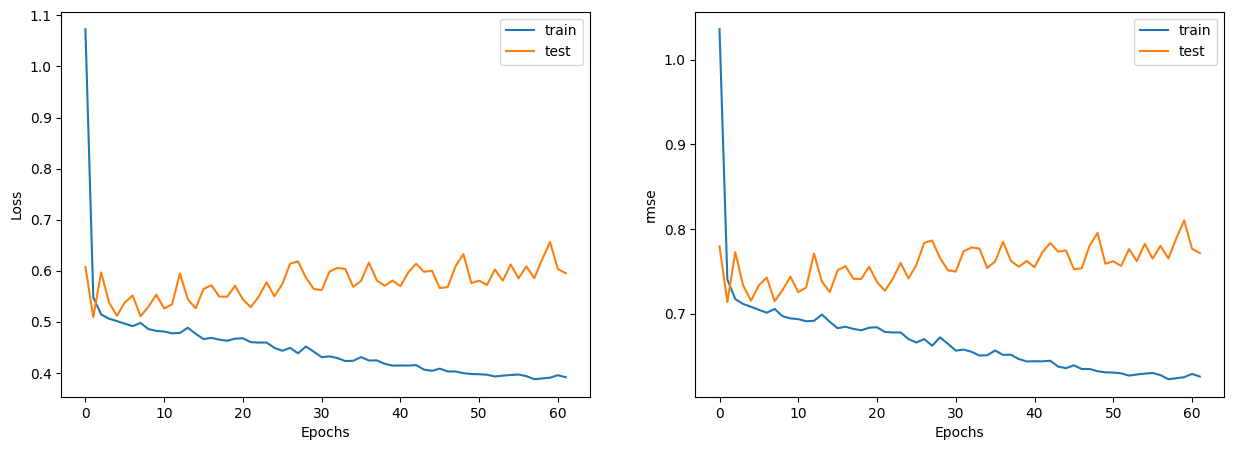

In [94]:
display_learning_curves(history)

## 5. 연습문제

---

이번 시간의 연습문제는 Cora 데이터를 직접 불러오고 전처리를 진행하며 GNN모델 훈련과 평가하는 전 과정을 복습하고, 파라미터를 직접 수정해가면서 최적의 결과를 찾아보는 과정을 수행해보겠습니다.
- 먼저 필요한 라이브러리를 불러옵니다.

In [95]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

### 5.1 데이터셋 불러오기

---

- Cora 데이터셋을 불러옵니다.
- 불러온 데이터셋의 'subject'를 0~7의 카테고리 형식으로 변환해줍니다.

In [ ]:
zip_file = keras.utils.get_file(
    fname="cora.tgz",
    origin="https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz",
    extract=True,
)
data_dir = os.path.join(os.path.dirname(zip_file), "cora")

In [136]:
data_dir = os.path.join("/content", "datasets", "cora_extracted","cora")

citations = pd.read_csv(
    os.path.join(data_dir, "cora.cites"),
    sep="\t",
    header=None,
    names=["target", "source"],
)
print("Citations shape:", citations.shape)

Citations shape: (5429, 2)


In [137]:
#papers
column_names = ["paper_id"] + [f"term_{idx}" for idx in range(1433)] + ["subject"]
papers = pd.read_csv(
    os.path.join(data_dir, "cora.content"), sep="\t", header=None, names=column_names,
)
print("Papers shape:", papers.shape)

Papers shape: (2708, 1435)


In [138]:
print(papers.subject.value_counts()) # 각 주제별 데이터 (paper) 수

subject
Neural_Networks           818
Probabilistic_Methods     426
Genetic_Algorithms        418
Theory                    351
Case_Based                298
Reinforcement_Learning    217
Rule_Learning             180
Name: count, dtype: int64


In [139]:
class_values = sorted(papers["subject"].unique()) #주제 이름만 선택
class_idx = {name: id for id, name in enumerate(class_values)}
paper_idx = {name: idx for idx, name in enumerate(sorted(papers["paper_id"].unique()))}

papers["paper_id"] = papers["paper_id"].apply(lambda name: paper_idx[name])
citations["source"] = citations["source"].apply(lambda name: paper_idx[name])
citations["target"] = citations["target"].apply(lambda name: paper_idx[name])
papers["subject"] = papers["subject"].apply(lambda value: class_idx[value])

### 5.2 GNN 인풋 준비

---

전체 데이터를 학습/시험 데이터로 분리합니다.

In [140]:
from sklearn.model_selection import train_test_split

node_ids = papers["paper_id"].to_numpy()
labels = papers["subject"].to_numpy()

x_temp, x_test, y_temp, y_test = train_test_split(
    node_ids, labels, test_size=0.15, stratify=labels, random_state=42
)
x_train, x_val, y_train, y_val = train_test_split(
    x_temp, y_temp, test_size=0.1765, stratify=y_temp, random_state=42
)

In [141]:
# 텐서로 변환
x_train = tf.convert_to_tensor(x_train)
x_val = tf.convert_to_tensor(x_val)
x_test = tf.convert_to_tensor(x_test)
y_train = tf.convert_to_tensor(y_train)
y_val = tf.convert_to_tensor(y_val)
y_test = tf.convert_to_tensor(y_test)

그래프 데이터는 아래 3가지 요소로 구성되어있습니다.
- node_feature : 노드의 특성을 포함하는 넘파이 배열입니다.
- edges : 노드들 간의 희소인접행렬을 나타내는 넘파이 배열입니다.
- edge_weights : 그래프의 노드 간의 관계를 정량화하는 edge 가중치를 포함하는 넘파이 배열입니다. \
각각의 정의해 graph_info에 담아줍니다.
- 위의 3가지를 준비하는 코드를 완성하면 됩니다.

In [142]:
edges = citations[["source", "target"]].to_numpy().T

edge_weights = tf.ones(shape=edges.shape[1])

node_features = tf.cast(
    papers.sort_values("paper_id")[feature_names].to_numpy(), dtype=tf.dtypes.float32
)


graph_info = (node_features, edges, edge_weights)

print("Edges shape:", edges.shape)
print("Nodes shape:", node_features.shape)

Edges shape: (2, 5429)
Nodes shape: (2708, 1433)


### 5.3 GNN 모델 준비

---

- GraphConvLayer를 완성합니다.
- GNN 모델을 생성하는 코드를 완성합니다.
- 완성된 GNN모델 구조를 확인합니다.

In [143]:
# GNN Layer 준비
class GraphConvLayer(layers.Layer):
    def __init__(
        self,
        hidden_units,
        dropout_rate=0.2,
        aggregation_type="mean",
        combination_type="concat",
        normalize=False,
        *args,
        **kwargs,
    ):
        super(GraphConvLayer, self).__init__(*args, **kwargs)

        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.normalize = normalize

        self.ffn_prepare = create_ffn(hidden_units, dropout_rate)
        if self.combination_type == "gated":
            self.update_fn = layers.GRU(
                units=hidden_units,
                activation="tanh",
                recurrent_activation="sigmoid",
                dropout=dropout_rate,
                return_state=True,
                recurrent_dropout=dropout_rate,
            )
        else:
            self.update_fn = create_ffn(hidden_units, dropout_rate)

    def prepare(self, node_repesentations, weights=None):
        # node_repesentations shape:  [num_edges, embedding_dim].
        messages = self.ffn_prepare(node_repesentations)
        if weights is not None:
            messages = messages * tf.expand_dims(weights, -1)
        return messages

    def aggregate(self, node_indices, neighbour_messages):
        # node_indices shape: [num_edges].
        # neighbour_messages shape: [num_edges, representation_dim].
        num_nodes = tf.math.reduce_max(node_indices) + 1
        if self.aggregation_type == "sum":
            aggregated_message = tf.math.unsorted_segment_sum(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "mean":
            aggregated_message = tf.math.unsorted_segment_mean(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "max":
            aggregated_message = tf.math.unsorted_segment_max(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        else:
            raise ValueError(f"Invalid aggregation type: {self.aggregation_type}.")

        return aggregated_message

    def update(self, node_repesentations, aggregated_messages):
        # node_repesentations shape: [num_nodes, representation_dim].
        # aggregated_messages shape: [num_nodes, representation_dim].
        if self.combination_type == "gru":
            # Create a sequence of two elements for the GRU layer.
            h = tf.stack([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "concat":
            # node_repesentations and aggregated_messages 붙힘 (concat)
            h = tf.concat([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "add":
            # node_repesentations and aggregated_messages 더하기
            h = node_repesentations + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        # Apply the processing function.
        node_embeddings = self.update_fn(h)
        if self.combination_type == "gru":
            node_embeddings = tf.unstack(node_embeddings, axis=1)[-1]

        if self.normalize:
            node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)
        return node_embeddings

    def call(self, inputs):
        """Process the inputs to produce the node_embeddings.

        inputs: a tuple of three elements: node_repesentations, edges, edge_weights.
        Returns: node_embeddings of shape [num_nodes, representation_dim].
        """

        node_repesentations, edges, edge_weights = inputs
        # Get node_indices (source) and neighbour_indices (target) from edges.
        node_indices, neighbour_indices = edges[0], edges[1]
        # neighbour_repesentations shape is [num_edges, representation_dim].
        neighbour_repesentations = tf.gather(node_repesentations, neighbour_indices)

        # Prepare the messages of the neighbours.
        neighbour_messages = self.prepare(neighbour_repesentations, edge_weights)
        # Aggregate the neighbour messages.
        aggregated_messages = self.aggregate(node_indices, neighbour_messages)
        # Update the node embedding with the neighbour messages.
        return self.update(node_repesentations, aggregated_messages)

In [144]:
# GNN 모델 선언
class GNNNodeClassifier(tf.keras.Model):
    def __init__(
        self,
        graph_info,
        num_classes,
        hidden_units,
        aggregation_type="sum",
        combination_type="concat",
        dropout_rate=0.2,
        normalize=True,
        *args,
        **kwargs,
    ):
        super(GNNNodeClassifier, self).__init__(*args, **kwargs)

        # Unpack graph_info to three elements: node_features, edges, and edge_weight.
        node_features, edges, edge_weights = graph_info
        self.node_features = node_features
        self.edges = edges
        self.edge_weights = edge_weights
        # Set edge_weights to ones if not provided.
        if self.edge_weights is None:
            self.edge_weights = tf.ones(shape=edges.shape[1])
        # Scale edge_weights to sum to 1.
        self.edge_weights = self.edge_weights / tf.math.reduce_sum(self.edge_weights)

        # Create a process layer.
        self.preprocess = create_ffn(hidden_units, dropout_rate, name="preprocess")
        # Create the first GraphConv layer.
        self.conv1 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv1",
        )
        # Create the second GraphConv layer.
        self.conv2 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv2",
        )
        # Create a postprocess layer.
        self.postprocess = create_ffn(hidden_units, dropout_rate, name="postprocess")
        # Create a compute logits layer.
        self.compute_logits = layers.Dense(units=num_classes, name="logits")

    def call(self, input_node_indices):
        # Preprocess the node_features to produce node representations.
        x = self.preprocess(self.node_features)
        # Apply the first graph conv layer.
        x1 = self.conv1((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x1 + x
        # Apply the second graph conv layer.
        x2 = self.conv2((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x2 + x
        # Postprocess node embedding.
        x = self.postprocess(x)
        # Fetch node embeddings for the input node_indices.
        node_embeddings = tf.gather(x, input_node_indices)
        # Compute logits
        return self.compute_logits(node_embeddings)

In [145]:
gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gnn_model",
)

# 노드 인덱스를 텐서로 변환
node_indices = tf.convert_to_tensor([1, 10, 100])

# 모델에 텐서 입력
print("GNN output shape:", gnn_model(node_indices))

# 모델 구조 확인
gnn_model.summary()

GNN output shape: tf.Tensor(
[[ 0.0500471  -0.03741337 -0.01024275  0.17477268 -0.01339338  0.06832955
  -0.10918894]
 [ 0.02137557  0.03379516  0.3327152   0.32314336 -0.02528154 -0.01757688
  -0.09664064]
 [-0.04409901  0.12032754  0.05584106  0.04404416  0.0609309  -0.19939026
   0.09880662]], shape=(3, 7), dtype=float32)


Model: "gnn_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ preprocess (Sequential)         │ (2708, 64)             │        97,508 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ graph_conv1 (GraphConvLayer)    │ ?                      │        13,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ graph_conv2 (GraphConvLayer)    │ ?                      │        13,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ postprocess (Sequential)        │ (2708, 64)             │         4,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ logits (Dense)                  │ (3, 7)                 │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 128,747 (502.92 KB)

 Trainable params: 124,985 (488.22 KB)

 Non-trainable params: 3,762 (14.70 KB)

### 5.4 GNN 모델 훈련 및 평가

---

- 파라미터를 정의합니다. (hidden_units = [32, 32], lr = 0.01, dropout_rate = 0.5, 300에포크, 배치 사이즈는 256으로 설정합니다.(이후 정의된 파라미터 값들을 수정해가며 결과를 확인해봅니다.)
- 훈련 결과를 시각화하는 코드를 완성합니다.
- 훈련을 진행합니다.
- 훈련 결과를 시각화하는 코드를 완성하고, 결과를 평가합니다.

In [146]:
#파라미터 정의
hidden_units = [64]
learning_rate = 0.005
dropout_rate = 0.4
num_epochs = 300
batch_size = 256

In [147]:
# 훈련결과 시각화 함수
def display_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "test"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2.plot(history.history["acc"])
    ax2.plot(history.history["val_acc"])
    ax2.legend(["train", "test"], loc="upper right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("accuracy")
    plt.show()

In [148]:
def run_experiment(model, x_train, y_train, x_val, y_val):
    # 모델 컴파일
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
    )

    # early stopping 선언
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=15, restore_best_weights=True
    )

    # 모델 훈련
    history = model.fit(
        x=x_train,
        y=y_train,
        validation_data=(x_val, y_val),
        epochs=num_epochs,
        batch_size=batch_size,
        callbacks=[early_stopping],
    )

    return history

In [149]:
#모델 학습
history = run_experiment(gnn_model, x_train, y_train, x_val, y_val)

Epoch 1/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 662ms/step - acc: 0.2991 - loss: 1.7509 - val_acc: 0.5995 - val_loss: 1.2195
Epoch 2/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - acc: 0.7282 - loss: 0.8662 - val_acc: 0.7174 - val_loss: 0.9460
Epoch 3/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - acc: 0.8958 - loss: 0.3631 - val_acc: 0.7469 - val_loss: 0.9044
Epoch 4/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - acc: 0.9633 - loss: 0.1294 - val_acc: 0.7273 - val_loss: 1.2446
Epoch 5/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - acc: 0.9868 - loss: 0.0655 - val_acc: 0.7174 - val_loss: 1.3017
Epoch 6/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - acc: 0.9885 - loss: 0.0400 - val_acc: 0.7371 - val_loss: 1.4267
Epoch 7/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - acc: 0.9949 - loss: 0.0206 - val_acc: 0.7322 - val_loss: 1.4735
Epoch 8/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - acc: 0.9956 - loss: 0.0133 - val_acc: 0.7322 - val_loss: 1.5692
Epoch 9/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - acc: 0.9983 - loss

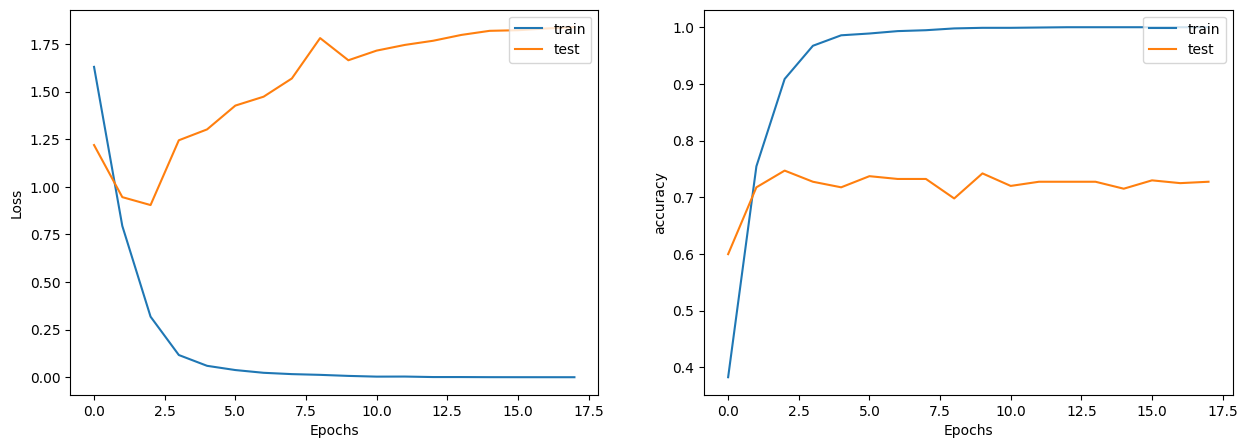

In [150]:
display_learning_curves(history)

In [151]:

_, test_accuracy = gnn_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 72.97%


파라미터들을 바꿔가면서 accuracy의 변화를 확인해봅시다.

# k-NN 기반 GNN 회귀 모델 구성: 소재물성 예측

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

# ----------- 1. 데이터 불러오기 및 결합 -----------
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train["is_train"] = 1
test["is_train"] = 0
df_all = pd.concat([train, test], ignore_index=True)

# ----------- 2. 특성 전처리 -----------
target_cols = ["formation_energy_ev_natom", "bandgap_energy_ev"]
id_col = "id"
feature_cols = df_all.drop(columns=[id_col] + target_cols, errors="ignore").columns

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_all[feature_cols])
node_features = tf.cast(X_scaled, tf.float32)

# ----------- 3. k-NN 그래프 생성 (엣지) -----------
k = 5
knn = NearestNeighbors(n_neighbors=k+1, metric="euclidean").fit(X_scaled)
knn_graph = knn.kneighbors(X_scaled, return_distance=False)

edge_list = []
for src, neighbors in enumerate(knn_graph):
    for dst in neighbors[1:]:
        edge_list.append([src, dst])
edges = np.array(edge_list).T  # shape: [2, num_edges]
edge_weights = tf.ones(shape=edges.shape[1])

# ----------- 4. 라벨 및 인덱스 정의 -----------
train_idx = df_all[df_all["is_train"] == 1].index.to_numpy()
test_idx = df_all[df_all["is_train"] == 0].index.to_numpy()

y_all = df_all[target_cols].fillna(0).to_numpy()
y_train = tf.convert_to_tensor(y_all[train_idx], dtype=tf.float32)
y_test = tf.convert_to_tensor(y_all[test_idx], dtype=tf.float32)

graph_info = (node_features, edges, edge_weights)

# ----------- 5. 유틸리티: FFN, GNN Layer -----------
def create_ffn(hidden_units, dropout_rate, name=None):
    layers_list = []
    for units in hidden_units:
        layers_list.append(layers.Dense(units, activation="relu"))
        layers_list.append(layers.Dropout(dropout_rate))
    return keras.Sequential(layers_list, name=name)

class GraphConvLayer(layers.Layer):
    def __init__(self, hidden_units, dropout_rate=0.2, aggregation_type="mean", combination_type="concat", normalize=False, **kwargs):
        super().__init__(**kwargs)
        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.normalize = normalize
        self.ffn_prepare = create_ffn(hidden_units, dropout_rate)
        self.update_fn = create_ffn(hidden_units, dropout_rate)

    def prepare(self, node_representations, weights=None):
        messages = self.ffn_prepare(node_representations)
        if weights is not None:
            messages *= tf.expand_dims(weights, -1)
        return messages

    def aggregate(self, node_indices, messages):
        num_nodes = tf.reduce_max(node_indices) + 1
        if self.aggregation_type == "mean":
            return tf.math.unsorted_segment_mean(messages, node_indices, num_segments=num_nodes)
        elif self.aggregation_type == "sum":
            return tf.math.unsorted_segment_sum(messages, node_indices, num_segments=num_nodes)
        elif self.aggregation_type == "max":
            return tf.math.unsorted_segment_max(messages, node_indices, num_segments=num_nodes)

    def update(self, node_representations, aggregated):
        if self.combination_type == "concat":
            h = tf.concat([node_representations, aggregated], axis=1)
        elif self.combination_type == "add":
            h = node_representations + aggregated
        else:
            raise ValueError("Invalid combination type")
        out = self.update_fn(h)
        return tf.nn.l2_normalize(out, axis=-1) if self.normalize else out

    def call(self, inputs):
        node_representations, edges, edge_weights = inputs
        src, dst = edges[0], edges[1]
        neighbor_repr = tf.gather(node_representations, dst)
        messages = self.prepare(neighbor_repr, edge_weights)
        aggregated = self.aggregate(src, messages)
        return self.update(node_representations, aggregated)

# ----------- 6. GNN 모델 정의 -----------
class GNNRegressor(keras.Model):
    def __init__(self, graph_info, hidden_units, output_units, dropout_rate=0.3):
        super().__init__()
        self.node_features, self.edges, self.edge_weights = graph_info
        self.edge_weights /= tf.reduce_sum(self.edge_weights)

        self.preprocess = create_ffn(hidden_units, dropout_rate)
        self.conv1 = GraphConvLayer(hidden_units, dropout_rate)
        self.conv2 = GraphConvLayer(hidden_units, dropout_rate)
        self.postprocess = create_ffn(hidden_units, dropout_rate)
        self.predictor = layers.Dense(output_units)

    def call(self, node_indices):
        x = self.preprocess(self.node_features)
        x1 = self.conv1((x, self.edges, self.edge_weights))
        x2 = self.conv2((x1, self.edges, self.edge_weights))
        x = self.postprocess(x2 + x1)
        node_repr = tf.gather(x, node_indices)
        return self.predictor(node_repr)

# ----------- 7. 학습 및 평가 -----------
gnn_model = GNNRegressor(graph_info, hidden_units=[64], output_units=2, dropout_rate=0.3)

gnn_model.compile(
    optimizer=keras.optimizers.Adam(1e-2),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="rmse")]
)

history = gnn_model.fit(
    x=train_idx,
    y=y_train,
    validation_split=0.15,
    epochs=200,
    batch_size=256,
    verbose=1
)

# 평가
_, test_rmse = gnn_model.evaluate(x=test_idx, y=y_test, verbose=0)
print(f"Test RMSE: {test_rmse:.4f}")
